**Problem statement**

#### Preforming the sentiment analysis on tweets in the twitter.

**1.Importing libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import re
import emoji
from collections import Counter
from wordcloud import WordCloud
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer,LancasterStemmer,SnowballStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer,PowerTransformer,StandardScaler,LabelEncoder

**2. Data Collection**

In [6]:
data = pd.read_csv(r"/content/drive/MyDrive/twitter.csv", encoding= 'latin-1',header= None,names= ["Target","UserId","Date","Flag","UserName","Text"])

In [7]:
df = data.copy()

In [8]:
df.head()

,Target,UserId,Date,Flag,UserName,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**3. EDA Before Pre-Processing**

In [9]:
df.shape

(1600000, 6)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Target    1600000 non-null  int64 
 1   UserId    1600000 non-null  int64 
 2   Date      1600000 non-null  object
 3   Flag      1600000 non-null  object
 4   UserName  1600000 non-null  object
 5   Text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
df.isnull().sum()

Target      0
UserId      0
Date        0
Flag        0
UserName    0
Text        0
dtype: int64

In [12]:
df.duplicated().sum()

0

In [13]:
df['Target'].value_counts()

0    800000
4    800000
Name: Target, dtype: int64

In [14]:
df['Target'] = df['Target'].map({0: 'Negative', 4: 'Positive'})

In [15]:
df['Target'].value_counts()

Negative    800000
Positive    800000
Name: Target, dtype: int64

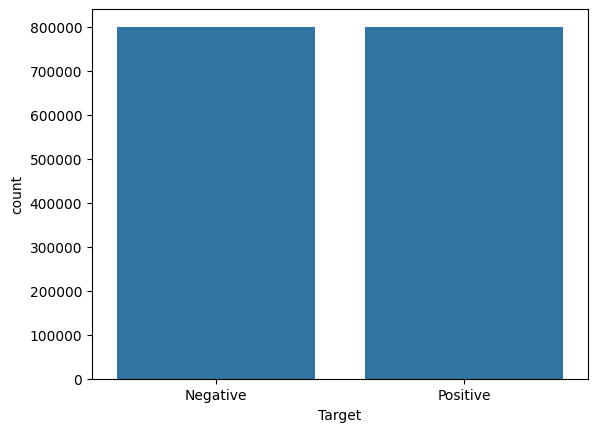

In [16]:
sns.countplot(data= df, x= 'Target')
plt.show()

In [17]:
feature_var = df['Text']

In [18]:
feature_var.head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: Text, dtype: object

In [19]:
def EDA_1(data):

    case = " ".join(data).islower()
    html = data.apply(lambda x:True if re.search("<.+?>",x) else False).sum()
    url = data.apply(lambda x:True if re.search("http[s]?://.+? +",x) else False).sum()
    unwanted = data.apply(lambda x:True if re.search("[]()*\-.:,@#$%&^!?/0-9']",x) else False).sum()

    count = 0
    for sen in data:
        for char in sen.split():
            if emoji.is_emoji(char):
                count += 1

    if case == False:
        print("Contains non lowercase letters")
    else:
        print('All are in lowercase letters')

    if html > 0:
        print("Contains html tags")
    else:
        print('No html tags')

    if url > 0:
        print("Contains urls")
    else:
        print('No urls')

    if unwanted > 0:
        print("Contains unwanted characters")
    else:
        print('No unwanted characters')

    if count > 0:
        print('Contains Emoji')
    else:
        print('No Emoji')

In [20]:
EDA_1(feature_var)

Contains non lowercase letters
No html tags
Contains urls
Contains unwanted characters
No Emoji


In [21]:
class_var = df['Target']

In [22]:
class_var.head()

0    Negative
1    Negative
2    Negative
3    Negative
4    Negative
Name: Target, dtype: object

In [23]:
class_var_encoding = LabelEncoder()

class_var = class_var_encoding.fit_transform(class_var)

class_var = pd.Series(class_var)

In [24]:
class_var.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [25]:
x_train,x_test,y_train,y_test = train_test_split(feature_var, class_var, test_size= 0.2, random_state= 1, stratify= class_var)

In [26]:
x_train,x_cv,y_train,y_cv = train_test_split(x_train, y_train, test_size= 0.2, random_state= 1, stratify= y_train)

In [27]:
x_train.head()

1160993    Mimis time! Carne asada was pretty bomb tonigh...
257015     sad to be going to the secret gathering withou...
780452                       Last day of college for summer 
329124     ok, bird just made me so sad! it tried to lay ...
365509     @michiFM i know and khloe/kourt! .IM SOO UPSET...
Name: Text, dtype: object

**4. Pre-Processing**

In [28]:
def emoji_remove(x):

    x = x.apply(lambda x : emoji.demojize(x))

    return x

In [29]:
def lowercase(x):

     return x.str.lower()

In [30]:
def html_tags(x):

    x = x.apply(lambda x:re.sub("<.+?>"," ",x))

    return x

In [31]:
def urls(x):

    x = x.apply(lambda x : re.sub("https[s]?://.+? +"," ",x))

    return x

In [32]:
def unwanted_characters(x):

    x = x.apply(lambda x : re.sub("[]()*\-.:,@#$%&^!?/0-9']"," ",x))

    return x

In [33]:
def lemmatization(x):

    list_stp = stopwords.words("english")
    wl = WordNetLemmatizer()

    def lemmatize_text(text):

        words = word_tokenize(text)
        lemmatized_words = [wl.lemmatize(word, pos="v") for word in words if word not in list_stp]

        return " ".join(lemmatized_words)

    return x.apply(lemmatize_text)

In [34]:
preprocesser_pipe = Pipeline([('Lowercase', FunctionTransformer(lowercase)),
                              ('Html_Tags', FunctionTransformer(html_tags)),
                              ('Urls', FunctionTransformer(urls)),
                              ("Emoji's", FunctionTransformer(emoji_remove)),
                              ('Unwanted Characters', FunctionTransformer(unwanted_characters)),
                              ('Lemmatization',FunctionTransformer(lemmatization))])

**5. EDA After Pre-Processing**

In [41]:
x_train = preprocesser_pipe.fit_transform(x_train)

eda_feature_var = pd.DataFrame(x_train, columns= ['Text'])

eda_class_var = pd.DataFrame(y_train, columns= ['Target'])

eda_df = pd.concat([eda_feature_var, eda_class_var], axis= 1)

In [42]:
eda_df.head()

,Text,Target
1160993,mimis time carne asada pretty bomb tonight lov...,1
257015,sad go secret gather without kristers,0
780452,last day college summer,0
329124,ok bird make sad try lay egg miss nest little ...,0
365509,michifm know khloe kourt im soo upsetttt,0


In [43]:
group_df = eda_df.groupby('Target')

neg_tweets = group_df.get_group(0)['Text']

pos_tweets = group_df.get_group(1)['Text']

In [44]:
neg_tweets_words = ' '.join(neg_tweets).split()

pos_tweets_words = ' '.join(pos_tweets).split()

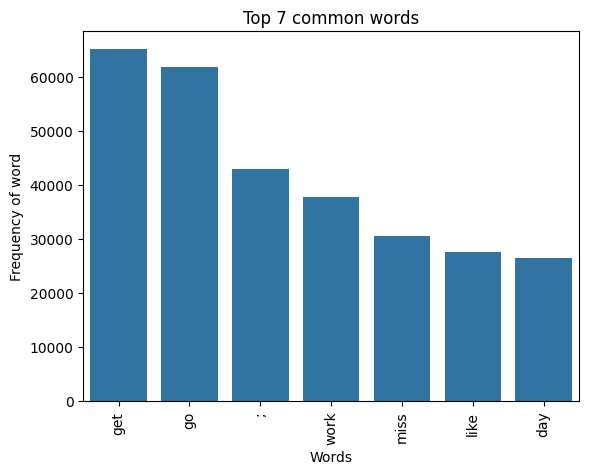

In [45]:
words = []
freq = []
for i,j in Counter(neg_tweets_words).most_common(7):
    words.append(i)
    freq.append(j)
sns.barplot(x= words, y= freq)
plt.xlabel('Words')
plt.ylabel('Frequency of word')
plt.title('Top 7 common words')
plt.xticks(rotation = 90)
plt.show()

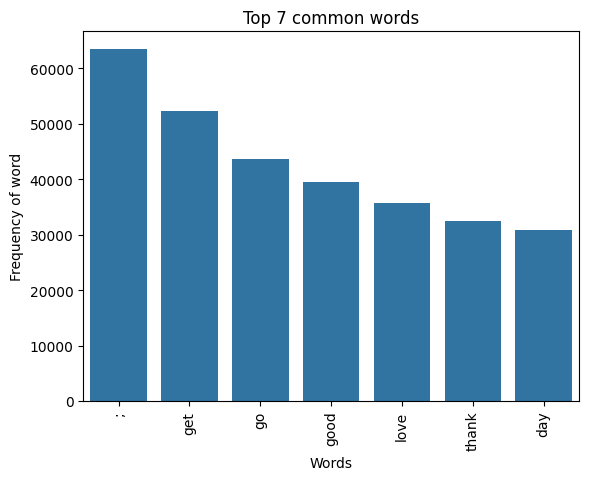

In [46]:
words = []
freq = []
for i,j in Counter(pos_tweets_words).most_common(7):
    words.append(i)
    freq.append(j)
sns.barplot(x= words, y= freq)
plt.xlabel('Words')
plt.ylabel('Frequency of word')
plt.title('Top 7 common words')
plt.xticks(rotation = 90)
plt.show()

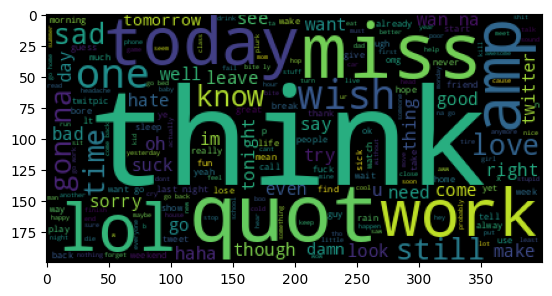

In [47]:
wc = WordCloud().generate(' '.join(neg_tweets))
plt.imshow(wc)
plt.show()

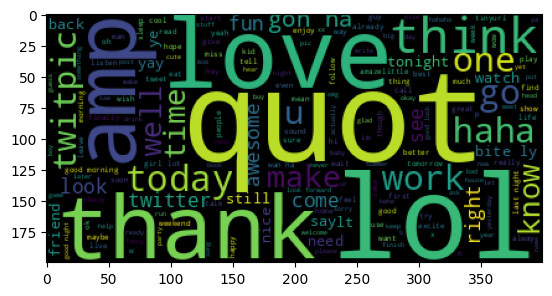

In [48]:
wc = WordCloud().generate(' '.join(pos_tweets))
plt.imshow(wc)
plt.show()

**6. Feature Engineering**

In [49]:
feature_extraction_pipe = Pipeline([('Pre-Processing',preprocesser_pipe),
                                    ('Vectorization',CountVectorizer(binary= True))])

In [50]:
final_x_train = feature_extraction_pipe.fit_transform(x_train)

final_x_cv = feature_extraction_pipe.transform(x_cv)

final_x_test = feature_extraction_pipe.transform(x_test)

In [51]:
pickle.dump(feature_extraction_pipe,open(r"/content/drive/MyDrive/Twitter_feature_extraction.pkl",'wb'))

**7. Training & Evalution**

In [52]:
for i in range(1,10):
    bernoulli = BernoulliNB(alpha= i)
    model = bernoulli.fit(final_x_train,y_train)
    print(('*'*18 + ' Alpha - {} ' + '*'*18).format(i))
    print(classification_report(y_train, model.predict(final_x_train)))

****************** Alpha - 1 ******************
              precision    recall  f1-score   support

           0       0.81      0.85      0.83    512000
           1       0.84      0.80      0.82    512000

    accuracy                           0.82   1024000
   macro avg       0.82      0.82      0.82   1024000
weighted avg       0.82      0.82      0.82   1024000

****************** Alpha - 2 ******************
              precision    recall  f1-score   support

           0       0.79      0.84      0.81    512000
           1       0.83      0.78      0.80    512000

    accuracy                           0.81   1024000
   macro avg       0.81      0.81      0.81   1024000
weighted avg       0.81      0.81      0.81   1024000

****************** Alpha - 3 ******************
              precision    recall  f1-score   support

           0       0.78      0.83      0.81    512000
           1       0.82      0.77      0.79    512000

    accuracy                          

In [53]:
for i in range(1,10):
    bernoulli = BernoulliNB(alpha= i)
    model = bernoulli.fit(final_x_train,y_train)
    print(('*'*18 + ' Alpha - {} ' + '*'*18).format(i))
    print(classification_report(y_cv, model.predict(final_x_cv)))

****************** Alpha - 1 ******************
              precision    recall  f1-score   support

           0       0.75      0.79      0.77    128000
           1       0.78      0.73      0.75    128000

    accuracy                           0.76    256000
   macro avg       0.76      0.76      0.76    256000
weighted avg       0.76      0.76      0.76    256000

****************** Alpha - 2 ******************
              precision    recall  f1-score   support

           0       0.75      0.79      0.77    128000
           1       0.78      0.73      0.76    128000

    accuracy                           0.76    256000
   macro avg       0.76      0.76      0.76    256000
weighted avg       0.76      0.76      0.76    256000

****************** Alpha - 3 ******************
              precision    recall  f1-score   support

           0       0.75      0.80      0.77    128000
           1       0.78      0.73      0.76    128000

    accuracy                          

**8. Testing**

In [54]:
bernoulli = BernoulliNB(alpha= 1)
final_model = bernoulli.fit(final_x_train,y_train)

In [55]:
print(classification_report(y_test, model.predict(final_x_test)))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77    160000
           1       0.78      0.72      0.75    160000

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



**9. Deploying**

In [56]:
pickle.dump(final_model,open(r"/content/drive/MyDrive/Twitter_model.pkl",'wb'))

In [61]:
m = feature_extraction_pipe.transform(x_test.iloc[[1]])   ## convert text into sprse matrix used b
pred = final_model.predict(m)                                #it shows predict value

if pred == 0:
  print("Negative")
else:
  print("Positive")

Positive
